In [1]:
import MDAnalysis as mda
import numpy as np
import os
from utils import *
import warnings 
import matplotlib.pyplot as plt

# Suppress warnings specific to MDAnalysis
warnings.filterwarnings("ignore", category=UserWarning, module="MDAnalysis")

c:\Users\gbonn\anaconda3\envs\md-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [52]:
# read in each of the substrate files
directory = 'substrates_initial/'
file_names = [f for f in os.listdir(directory)]
file_names = ['1.pdb','6.pdb','14.pdb','18.pdb']
# Defined in the array below are the distances away from ThDP atoms to substrate atoms 
# determine by the optimized structure of substrate 6 and are used to place the aka head atoms
# radii are in order of (columns) C1, N1, N2, S1 and then rows (C2, C3, O1) 
# so C1 is (0,0) Angstroms away from C2 
radii = [
    [1.539,2.562,3.389,2.880],
    [2.533,3.205,4.764,3.784],
    [2.393,2.973,2.592,3.893]
]

In [12]:
# load receptor universe and extract the different parts of the protein int1 receptor 
receptor = mda.Universe('2AG0_receptor.pdb')
head_dir = '2AG0/'
# output the ThDP cofactor
ThDP = receptor.select_atoms("resname TPP")
write_universe(head_dir+'receptor/','TPP.pdb',ThDP)
# output just the protein and edit the file so it is Amber readable 
protein = receptor.select_atoms(f"protein or resname MG")
write_universe(head_dir+'receptor/','protein.pdb',protein)
edit_protein_files(head_dir,'receptor/protein.pdb')
# output the water
try:
    water = receptor.select_atoms(f"resname WAT")
    water.atoms.write(head_dir+'/receptor/water.pdb')
except:
    print('No water to write')

# output the receptor (everything besides ThDP)
protein_MG_water = receptor.select_atoms("not resname TPP")
protein_MG_water.atoms.write(head_dir+'/receptor/receptor.pdb')
edit_protein_files(head_dir,'receptor/receptor.pdb')



Directory '2AG0/receptor/' already exists.
File 'TPP.pdb' has been written in '2AG0/receptor/'.
Directory '2AG0/receptor/' already exists.
File 'protein.pdb' has been written in '2AG0/receptor/'.
Edited  2AG0//receptor/protein.pdb
No water to write
Edited  2AG0//receptor/receptor.pdb


In [9]:

# get the important indexes of the ThDP atoms 
ThDP_important_indexes = get_ThDP_indexes(ThDP)

# get the coordinates of important atoms in ThDP
C1_coords = get_atom_position(ThDP,ThDP_important_indexes['C1'])
N1_coords = get_atom_position(ThDP,ThDP_important_indexes['N1'])
N2_coords = get_atom_position(ThDP,ThDP_important_indexes['N2'])
S1_coords = get_atom_position(ThDP,ThDP_important_indexes['S1'])

# ThDP C1, N1, N2, S1 atom coords that will be treated as sphere centers 
centers = np.array([C1_coords,N1_coords,N2_coords,S1_coords])

# we will use the average vector of S1C1 and N1C1 to get a guess of where C2 should be located
vector_S1_to_C1 = C1_coords - S1_coords
vector_N1_to_C1 = C1_coords - N1_coords
avg_vector = (vector_S1_to_C1 + vector_N1_to_C1)/2
unit_vector = avg_vector / np.linalg.norm(avg_vector)
guess_C2 = C1_coords + unit_vector * 1.54 # C2 should be located 1.54 A away from C1


Taking best guess at ring N
Taking best guess at carbanion


In [76]:
# iterate through all substrates to align to the int1 geometry
all_substrate_rotation_clashes = []
for curr_file_name in file_names:
    print(curr_file_name)
    # load substrate universe
    file_start = curr_file_name.split('.')[0]
    substrate = mda.Universe(directory+curr_file_name)
    # identify the atoms that comprise the aka substrates 

    substrate_important_indexes = get_substrate_aka_indexes(substrate.atoms)
    # initial coords of C2, C3, and O1 
    initial_positions = [get_atom_position(substrate,substrate_important_indexes['C2']),get_atom_position(substrate,substrate_important_indexes['C3']),get_atom_position(substrate,substrate_important_indexes['O1'])]

    # we go through two rounds of optimization, first using the guess location of 
    # C2 as the starting position for each atom we are trying to place (C2,C3,O1) 
    initial_guess = np.hstack([guess_C2 for i in range(3)])
    C2_optimized, C3_optimized, O1_optimized = optimize_points(centers, initial_guess, radii)
    all_optimized = [C2_optimized, C3_optimized, O1_optimized]

    # get the final error for each atom's position 
    C2_err = atom_objective(C2_optimized, centers, radii[0])
    C3_err = atom_objective(C3_optimized, centers, radii[1])
    O1_err = atom_objective(O1_optimized, centers, radii[2])

    # use the atom with the minimum error for the next round of optimization
    all_errors = [C2_err,C3_err,O1_err]
    min_error_index = all_errors.index(min(all_errors))
    redo_initial_guess = np.hstack([all_optimized[min_error_index] for i in range(3)])
    C2_reoptimized, C3_reoptimized, O1_reoptimized = optimize_points(centers, redo_initial_guess, radii)
    
    final_positions = [C2_reoptimized, C3_reoptimized, O1_reoptimized]

    # Get the rotation and translation matrix from our initial substrate to our int1 geoemtry
    R, t = kabsch_algorithm(initial_positions,final_positions)
    
    # make a copy of the substrate object and update atom positions by aligning aka head atoms
    substrate_aka_aligned = substrate.copy()
    for i in range(0,len(substrate_aka_aligned.atoms.positions)):
        atom_coords = substrate_aka_aligned.atoms[i].position
        new_coords = np.dot(R, atom_coords) + t
        substrate_aka_aligned.atoms[i].position = new_coords

    # get the updated coords for important atoms 
    C2_coords = substrate_aka_aligned.atoms.positions[substrate_important_indexes['C2']]
    O1_coords = substrate_aka_aligned.atoms.positions[substrate_important_indexes['O1']]
    C3_coords = substrate_aka_aligned.atoms.positions[substrate_important_indexes['C3']]
    R_coords =  substrate_aka_aligned.atoms.positions[substrate_important_indexes['R']]

    # target angles represents the optimized angles of C1-C2-R ,O1-C2-R ,C3-C2-R
    # we will use these to help us reposition the R group first atom 
    target_angles = [111.1,110.2,107.5]
    R_coords_opt = optimize_angles(R_coords,C1_coords,C2_coords,O1_coords,C3_coords,target_angles)

    # get a rotation and translation matrix from the original to the optimized R location 
    R_tail, t_tail = kabsch_algorithm([R_coords,C2_coords],[R_coords_opt,C2_coords])
    
    # apply rotation and translation transformation to only the tail atoms 
    substrate_tail_atom_indexes = [i for i in range(0,len(substrate.atoms)) if i not in substrate_important_indexes.values()]
    substrate_tail_atom_indexes.append(substrate_important_indexes['R'])

    # make a copy of the substrate object and update tail atom positions
    substrate_aligned = substrate_aka_aligned.copy()
    for i in substrate_tail_atom_indexes:
        atom_coords = substrate_aligned.atoms[i].position
        new_coords = np.dot(R_tail, atom_coords) + t_tail
        substrate_aligned.atoms[i].position = new_coords

    # add the substrate and ThDP to a single INI universe
    ini_universe = mda.Merge(substrate_aligned.atoms,ThDP.atoms)
    for atom in ini_universe.atoms:
        atom.residue.resid = 1
        atom.residue.resname = "INI"
        atom.record_type = "HETATM"
    
    # determine hwo the indexes of INI and ThDP have shifted and consolidate dictionary
    ini_substrate_shift = determine_index_shift(substrate_aligned,ini_universe,substrate_tail_atom_indexes)
    ini_ThDP_shift = determine_index_shift(ThDP,ini_universe,list(ThDP_important_indexes.values()))

    ini_tail_atom_indexes = [i + ini_substrate_shift for i in substrate_tail_atom_indexes]
    ini_important_indexes = {}
    for key in substrate_important_indexes:
        ini_important_indexes[key] = substrate_important_indexes[key] + ini_substrate_shift

    for key in ThDP_important_indexes:
        ini_important_indexes[key] = ThDP_important_indexes[key] + ini_ThDP_shift    

    # add ini and receptor to the same universe to form the full complex
    complex = mda.Merge(protein_MG_water.atoms,ini_universe.atoms)
    
    # determine how much the indexing has changed and update dictionary
    complex_shift = determine_index_shift(ini_universe,complex,substrate_tail_atom_indexes)
    complex_tail_atom_indexes = [i + complex_shift for i in ini_tail_atom_indexes]

    for key in ini_important_indexes:
        ini_important_indexes[key] = ini_important_indexes[key] + complex_shift

    # get the atoms involved in the bond that we are going to rotate around (carbonyl carbon to first atom in the tail)
    atom1_index = ini_important_indexes['C2'] 
    atom2_index = ini_important_indexes['R']  
    complex_tail_atom_indexes.remove(atom2_index)
    atoms_to_rotate =  complex_tail_atom_indexes 
    
    # fix the R atom bonded to C2 and allow the tail atoms to rotate to minimize clashes 
    pdb_indexes = [i+1 for i in complex_tail_atom_indexes]
    degrees_rotated = 0
    threshold = bond_dists['C-C']
    num_clash = atom_clash_objective(complex,pdb_indexes,threshold)
    all_degrees_rotated = [0]
    all_clashes =[num_clash]
    min_num_clash = num_clash
    curr_angle_streak = [0]
    longest_angle_streak = [0]
    while degrees_rotated <= 360:
            
        rotated_complex = rotate_atoms(complex.copy(), atom1_index, atom2_index, atoms_to_rotate, degrees_rotated)
        num_clash = get_atom_clashes(rotated_complex,pdb_indexes,threshold)
        
        all_degrees_rotated.append(degrees_rotated)
        all_clashes.append(num_clash)

        if num_clash == min_num_clash: # if the streak is continuing
            curr_angle_streak.append(degrees_rotated) # add the current angle to the current streak
        elif num_clash < min_num_clash: # if we have found a more favorable position
            curr_angle_streak = [degrees_rotated] # start over 
            min_num_clash = num_clash
        else: # if we increase from the current minimum record this streak
            # if we have found a new longest streak 
            if len(longest_angle_streak) < len(curr_angle_streak):
                longest_angle_streak = curr_angle_streak
            curr_angle_streak = []

        degrees_rotated += 5

    len_longest_streak = len(longest_angle_streak)
    median_min_angle = longest_angle_streak[len_longest_streak//2]
    min_rotated_complex = rotate_atoms(complex.copy(), atom1_index, atom2_index, atoms_to_rotate, median_min_angle)

    all_substrate_rotation_clashes.append(all_clashes)

    receptor = min_rotated_complex.select_atoms("not resname INI and not resname WAT")
    receptor_dir = head_dir+"complexes/"+file_start
    receptor_file_name = "receptor.pdb"
    write_universe(receptor_dir, receptor_file_name, receptor)
    edit_protein_files(receptor_dir,receptor_file_name)


    ini_final = min_rotated_complex.select_atoms("resname INI")
    ini_dir = head_dir+"complexes/"+file_start
    ini_file_name = "ini.pdb"
    write_universe(ini_dir, ini_file_name, ini_final)


1.pdb
NOT CONVERGED
CONVERGED
CONVERGED
Directory '2AG0/complexes/1' already exists.
File 'receptor.pdb' has been written in '2AG0/complexes/1'.
Edited  2AG0/complexes/1/receptor.pdb
Directory '2AG0/complexes/1' already exists.
File 'ini.pdb' has been written in '2AG0/complexes/1'.
6.pdb
NOT CONVERGED
CONVERGED
NOT CONVERGED
Directory '2AG0/complexes/6' already exists.
File 'receptor.pdb' has been written in '2AG0/complexes/6'.
Edited  2AG0/complexes/6/receptor.pdb
Directory '2AG0/complexes/6' already exists.
File 'ini.pdb' has been written in '2AG0/complexes/6'.
14.pdb
NOT CONVERGED
CONVERGED
CONVERGED
Directory '2AG0/complexes/14' already exists.
File 'receptor.pdb' has been written in '2AG0/complexes/14'.
Edited  2AG0/complexes/14/receptor.pdb
Directory '2AG0/complexes/14' already exists.
File 'ini.pdb' has been written in '2AG0/complexes/14'.
18.pdb
NOT CONVERGED
CONVERGED
CONVERGED
Directory '2AG0/complexes/18' already exists.
File 'receptor.pdb' has been written in '2AG0/complexe

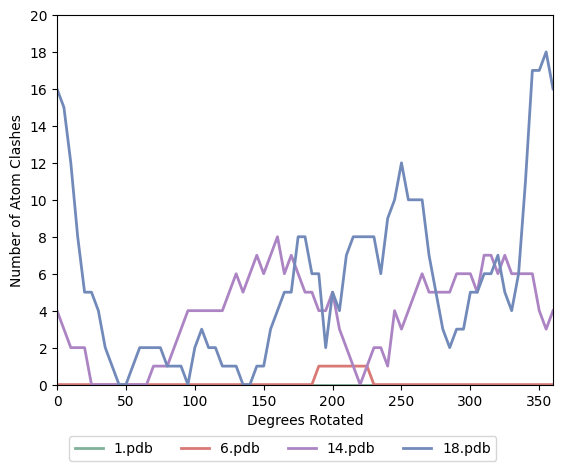

In [77]:
colors = ['#80B199','#D87976','#AC84C3','#728AB9']
for i in range(0,len(file_names)):
    plt.plot(all_degrees_rotated,all_substrate_rotation_clashes[i],label=file_names[i],color=colors[i],linewidth=2)

plt.xlabel('Degrees Rotated')
plt.ylabel('Number of Atom Clashes')
plt.yticks(np.arange(0, 22, 2.0))
plt.xlim(0,360)
plt.ylim(0,20)
plt.legend(bbox_to_anchor=(0.9, -0.12),ncol=len(file_names))


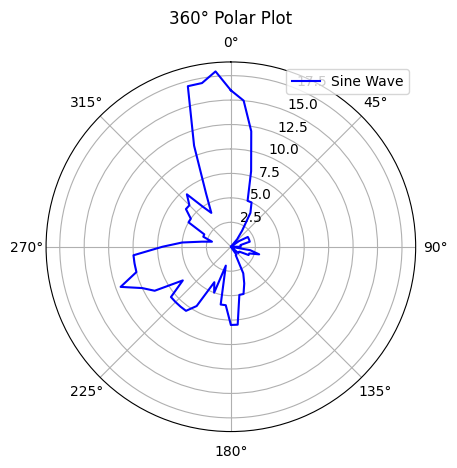

In [78]:
# Convert angles to radians for polar plotting
angles_rad = np.radians(all_degrees_rotated)

# Create a polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(angles_rad, all_substrate_rotation_clashes[-1], label='Sine Wave', color='blue')

# Customize the plot
ax.set_theta_zero_location('N')  # Set 0 degrees to point north
ax.set_theta_direction(-1)  # Set clockwise direction
ax.set_title("360° Polar Plot", va='bottom')
ax.legend()